In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [3]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [4]:
fake_df['truth'] = 0
true_df['truth'] = 1
all_news_df = pd.concat([fake_df, true_df])

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report

In [6]:
def get_X_y_splits(df, X_col, y_col='truth'):
    ''' Takes a dataframe and returns a train test split for labeled data.
    Input: DataFrame, X column name (string), target column name (string).
    Ouput: X_train, X_test, y_train, y_test'''
    X = df[X_col].values
    y = df[y_col].values
    return train_test_split(X, y)

In [7]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'text')

In [8]:
bayes_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    # ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
    ])

In [9]:
bayes_clf.fit(X_train, y_train)
bayes_predicted = bayes_clf.predict(X_test)
bayes_clf.score(X_test, y_test)

0.9696213808463252

In [10]:
svm_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    # ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(alpha=.0001))
    ])

In [11]:
svm_clf.fit(X_train, y_train)
svm_predicted = svm_clf.predict(X_test)
svm_clf.score(X_test, y_test)

0.9938530066815144

In [24]:
tfidf_bayes_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', ComplementNB())
    ])

In [25]:
tfidf_bayes_clf.fit(X_train, y_train)
tfidf_bayes_clf_predicted = tfidf_bayes_clf.predict(X_test)
tfidf_bayes_clf.score(X_test, y_test)

0.9549220489977728

(0.0, 0.2)

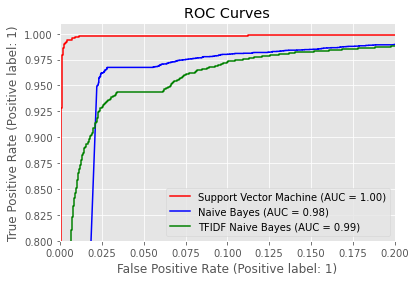

In [26]:
fig, ax = plt.subplots()
plot_roc_curve(svm_clf, X_test, y_test, name='Support Vector Machine', ax=ax, color='red')
plot_roc_curve(bayes_clf, X_test, y_test, name='Naive Bayes', ax=ax, color='blue')
plot_roc_curve(tfidf_bayes_clf, X_test, y_test, name='TFIDF Naive Bayes', ax=ax, color='green')
ax.set_title('ROC Curves')
ax.set_ylim(.8,1.01)
ax.set_xlim(0,.2)

In [15]:
confusion_matrix(y_test, svm_predicted)

array([[5767,   47],
       [  22, 5389]])

In [16]:
confusion_matrix(y_test, bayes_predicted)

array([[5649,  165],
       [ 176, 5235]])

In [27]:
confusion_matrix(y_test, tfidf_bayes_clf_predicted)

array([[5615,  199],
       [ 307, 5104]])

In [17]:
print(classification_report(y_test, svm_predicted, target_names=['Fake News','Real News']))

              precision    recall  f1-score   support

   Fake News       1.00      0.99      0.99      5814
   Real News       0.99      1.00      0.99      5411

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

